# Script de python para realizar el pre-procesamiento

Para poder predecir la tasa de morosidad de microempresas a cajas municipales, se buscaron datasets de acceso abierto en las páginas oficiales del estado. En la base de datos de la SBS se pueden conseguir archivos .XLS que datan desde 2009 hasta 2025 con información mensual de la tasa de morosidad en porcentajes que diferentes empresas (Grandes empresas, MIPES y microempresas) incurren en las diferentes cajas. Se decidió que este sería el target, mientras que los features se recopilaron de las encuestas nacionales "ENAHO" que realiza el INEI, ya que cuenta con información económica por hogar relevante para el modelo. Estas bases de datos se relacionan debido a que las microempresas constan de máximo 10 trabajadores, tienen fuentes de ingreso anuales no superiores a 10 UIT, y constituyen gran parte de los trabajos peruanos. El objetivo de este pre-procesamiento es analizar cada dataset, imputarlo, filtrarlo y unirlos para formar un dataset final.

Primero se decide analizar las bases de datos de la tasa de morosidad. Después de una revisión general, procedo a realizar una limpieza general para todos los meses y seleccionando solo el registro de microempresas. Luego se concatena mes a mes para todos los años dede 2009 hasta 2024, sin contar el 2020 y 2021 por el gran impacto del COVID y sin contar el 2025 porque los datos del ENAHO disponibles se encuentran hasta 2024.

In [ ]:
import pandas as pd
import os

ruta_base = "C:/Users/Joaquin/Desktop/Joaquin/2025-1/IA aplicada/Dataset IA"
anios = [anio for anio in range(2009, 2025) if anio not in [2020, 2021]]

mes_map = {
    'en': 1, 'fe': 2, 'ma': 3, 'ab': 4, 'my': 5, 'jn': 6,
    'jl': 7, 'ag': 8, 'se': 9, 'oc': 10, 'no': 11, 'di': 12
}

# Función para archivos estándar
def limpiar_excel(nombre_archivo, anio, mes_num):
    try:
        if anio == 2009: df = pd.read_excel(nombre_archivo, skiprows=4, usecols=lambda x: True, skipfooter=3, index_col=0)
        elif ((anio == 2010) & (mes_num < 7) & (mes_num != 3)): df = pd.read_excel(nombre_archivo, skiprows=3, usecols="A:P", skipfooter=3, index_col=0)
        elif ((anio == 2010) & (mes_num < 9)): df = pd.read_excel(nombre_archivo, skiprows=4, usecols="A:P", skipfooter=3, index_col=0)
        elif ((anio < 2014) & (mes_num < 6)): df = pd.read_excel(nombre_archivo, skiprows=4, usecols="B:Q", skipfooter=6, index_col=0)
        else: df = pd.read_excel(nombre_archivo, skiprows=4, usecols="B:P", skipfooter=6, index_col=0)
        df = df.dropna(how='all')
        df = df[~((df.isna()) | (df == 0)).all(axis=1)]
        df = df[df.index.str.contains("Créditos a microempresas", case=False, na=False)]
        df = df.drop(columns=["CAJAS MUNICIPALES DE AHORRO Y CREDITO", "TOTAL CAJAS MUNICIPALES"], errors='ignore')
        df["Fecha"] =  pd.Timestamp(anio, mes_num, 1)
        df = df.reset_index()
        df = df.drop(columns=["Concepto"])
        return df
    except Exception as e:
        print(f"[ESTANDAR] Error procesando {nombre_archivo}: {e}")
        return None


# Almacena los DataFrames válidos
todos_los_dfs = []

for anio in anios:
    carpeta_anio = os.path.join(ruta_base, str(anio))
    if not os.path.exists(carpeta_anio):
        print(f"Carpeta no encontrada: {carpeta_anio}")
        continue

    archivos = [f for f in os.listdir(carpeta_anio) if f.startswith("C-1242") and f.endswith(".XLS")]



    for archivo in archivos:
        ruta_archivo = os.path.join(carpeta_anio, archivo)
        nombre_solo = os.path.basename(ruta_archivo)
        mes_abrev = nombre_solo.split('-')[2][:2].lower()
        mes_num = mes_map.get(mes_abrev, None)

        if mes_num is None:
            print(f"Mes no reconocido en: {archivo}")
            continue

        # Selecciona la función según el caso
        df = limpiar_excel(ruta_archivo, anio, mes_num)

        if df is not None:
            todos_los_dfs.append(df)

# Concatenar y exportar
todos_los_dfs = [df for df in todos_los_dfs if df is not None]

if not todos_los_dfs:
    raise ValueError("No se procesó ningún archivo correctamente.")

df_morosidad = pd.concat(todos_los_dfs)
df_morosidad = df_morosidad.dropna(axis = 1)
df_morosidad = df_morosidad.sort_values("Fecha").reset_index(drop=True)



df_morosidad.head(15)

,CMAC Arequipa,CMAC Cusco,CMAC Del Santa,CMAC Huancayo,CMAC Ica,CMAC Maynas,CMAC Paita,CMAC Piura,CMAC Tacna,CMAC Trujillo,CMCP Lima,Fecha
0,5.08,4.61,8.57,4.79,7.49,9.29,4.79,7.61,4.46,5.09,4.56,2009-05-01
1,5.05,4.75,9.09,5.13,7.63,8.96,4.93,7.82,4.47,5.46,4.46,2009-06-01
2,5.21,4.92,9.16,5.31,7.55,8.99,5.01,8.03,4.52,5.95,4.28,2009-07-01
3,5.35,4.78,8.37,5.63,7.05,9.21,5.27,8.21,4.60,6.02,4.01,2009-08-01
4,5.01,4.65,8.99,5.61,7.38,9.25,5.21,8.23,4.70,6.25,3.81,2009-09-01
5,5.47,4.71,9.16,5.79,7.72,9.18,5.45,8.33,4.66,6.66,3.77,2009-10-01
6,5.70,4.71,9.10,5.59,7.44,9.44,5.53,8.39,4.58,6.99,3.61,2009-11-01
7,4.87,4.32,8.68,5.09,6.19,9.03,5.57,8.54,3.81,7.00,3.13,2009-12-01
8,5.67,5.03,10.14,5.95,6.96,9.83,5.50,9.19,4.77,8.15,2.84,2010-01-01
9,5.95,5.44,10.68,6.41,7.50,10.11,5.69,8.79,5.08,8.30,2.67,2010-02-01


In [ ]:
df_morosidad_largo = df_morosidad.melt(id_vars='Fecha', var_name='Caja', value_name='Morosidad')
df_morosidad_largo.head(20)

,Fecha,Caja,Morosidad
0,2009-05-01,CMAC Arequipa,5.08
1,2009-06-01,CMAC Arequipa,5.05
2,2009-07-01,CMAC Arequipa,5.21
3,2009-08-01,CMAC Arequipa,5.35
4,2009-09-01,CMAC Arequipa,5.01
5,2009-10-01,CMAC Arequipa,5.47
6,2009-11-01,CMAC Arequipa,5.70
7,2009-12-01,CMAC Arequipa,4.87
8,2010-01-01,CMAC Arequipa,5.67
9,2010-02-01,CMAC Arequipa,5.95


Luego se revisa los dataset de ENAHO, que son anuales. Después de leer el diccionario con la información de cada variables se seleccionan aquellas que tienen mayor relevancia economíca. Además se recopila los datos de año, mes y ubigeo para poder concatenar este dataset con el de la tasa de morosidad. Además se imputan datos de la variable pobreza estimando de forma matemática los valores para el año 2017, ya que en esa año esta variable no se tomó en cuenta. Se utilizaron formulas oficiales de clasificación de pobreza extrema, pobreza y no pobreza para clasificar estos datos.

In [ ]:
# Ruta base 
base_path = "C:/Users/Joaquin/Desktop/Joaquin/2025-1/IA aplicada/Dataset IA"

# Años válidos
anios = [anio for anio in range(2009, 2025) if anio not in [2020, 2021]]

# Variables a conservar
variables = [
    "AÑO","MES", "UBIGEO", "MIEPERHO", "PERCEPHO", "TOTMIEHO", 
    "IA01HD", "GA03HD", "INGBRUHD", "INGNETHD", "INGINDHD",
    "PAGESPHD", "INSEDTHD", "INSEDLHD", "POBREZA"
]

# Acumulador
lista_agregados = []

def detectar_separador(path):
    with open(path, encoding="latin1") as f:
        primera_linea = f.readline()
        if '|' in primera_linea and ',' not in primera_linea:
            return '|'
        return ','


# Procesamiento año por año
for anio in anios:
    carpeta = os.path.join(base_path, str(anio))

    # Nombres de archivos según año
    if anio <= 2015:
        archivo_sumaria = f"SUMARIA-{anio}.csv"
    else:
        sufijo = str(anio)[2:]
        archivo_sumaria = f"Sumaria-20{sufijo}-12g.csv"

    if anio == 2022:
        archivo_enaho = "Enaho01-2022-100.csv"
    else:
        archivo_enaho = f"Enaho01a-{anio}-500.csv"

    # Rutas completas
    ruta_sumaria = os.path.join(carpeta, archivo_sumaria)
    ruta_enaho = os.path.join(carpeta, archivo_enaho)

    try:
        # Detectar separadores
        sep_sumaria = detectar_separador(ruta_sumaria)
        sep_enaho = detectar_separador(ruta_enaho)

        # Leer archivos con separador correcto
        sumaria = pd.read_csv(ruta_sumaria, sep=sep_sumaria, encoding="latin1", engine="python")
        enaho = pd.read_csv(ruta_enaho, sep=sep_enaho, encoding="latin1", engine="python")

        
        sumaria.columns = sumaria.columns.str.upper()
        enaho.columns = enaho.columns.str.upper()

        ubigeo_dict = enaho[['UBIGEO']].drop_duplicates().dropna()
        df = pd.merge(sumaria, ubigeo_dict, on="UBIGEO", how="left")
        
        # Estimar pobreza si no está la columna original
        if "POBREZA" not in df.columns:
            # Asegura que las columnas requeridas existen
            if "INGBRUHD" in df.columns and "TOTMIEHO" in df.columns:
                df["ING_PC"] = df["INGBRUHD"] / df["TOTMIEHO"]

                def estimar_pobreza(pc):
                    if pd.isna(pc):
                        return None
                    if pc < 183.81:
                        return 1  # pobreza extrema
                    elif pc < 338.52:
                        return 2  # pobreza
                    else:
                        return 3  # no pobre

                df["POBREZA"] = df["ING_PC"].apply(estimar_pobreza)
                print(f"⚠️ POBREZA estimada en año {anio}")
            else:
                raise ValueError("No se puede estimar POBREZA: faltan ING_BRUHD o TOTMIEHO")

        df = df[variables].copy()
        df = df.rename(columns={"MES": "Mes"})

        df_agregado = df.groupby(["UBIGEO", "Mes"]).agg({
            "MIEPERHO": "mean",
            "PERCEPHO": "mean",
            "TOTMIEHO": "mean",
            "IA01HD": "mean",
            "GA03HD": "mean",
            "INGBRUHD": "mean",
            "INGNETHD": "mean",
            "INGINDHD": "mean",
            "PAGESPHD": "mean",
            "INSEDTHD": "mean",
            "INSEDLHD": "mean",
            "POBREZA": "mean"
        }).reset_index()

        df_agregado["Departamento"] = df_agregado["UBIGEO"].astype(str).str[:2]
        df_agregado["Año"] = anio

        lista_agregados.append(df_agregado)

        print(f"✅ Procesado: {anio}")

    except Exception as e:
        print(f"❌ Error en año {anio}: {e}")

# Concatenar todos los años
df_final_enaho_sumaria = pd.concat(lista_agregados, ignore_index=True)

# Mostrar primeras filas
df_final_enaho_sumaria.head()


✅ Procesado: 2009
✅ Procesado: 2010
✅ Procesado: 2011
✅ Procesado: 2012
✅ Procesado: 2013
✅ Procesado: 2014
✅ Procesado: 2015
✅ Procesado: 2016
⚠️ POBREZA estimada en año 2017
✅ Procesado: 2017
✅ Procesado: 2018
✅ Procesado: 2019
✅ Procesado: 2022
✅ Procesado: 2023
✅ Procesado: 2024


,UBIGEO,Mes,MIEPERHO,PERCEPHO,TOTMIEHO,IA01HD,GA03HD,INGBRUHD,INGNETHD,INGINDHD,PAGESPHD,INSEDTHD,INSEDLHD,POBREZA,Departamento,Año
0,10101,1,5.29,2.86,5.29,1245.14,0.0,2284.29,1476.86,30409.29,0.00,42.57,42.57,2.57,10,2009
1,10101,2,4.50,3.00,4.50,463.67,0.0,8800.50,8070.17,6009.97,925.50,0.00,0.00,2.67,10,2009
2,10101,3,4.00,2.79,4.07,796.43,0.0,8254.19,7142.10,6839.07,1120.14,104.57,104.57,2.64,10,2009
3,10101,4,3.64,2.00,3.64,3600.00,0.0,10936.48,7326.11,7758.09,245.45,1711.45,1711.45,3.00,10,2009
4,10101,5,4.17,2.50,4.17,1909.83,0.0,8926.83,6876.00,9983.83,2356.00,0.00,0.00,3.00,10,2009


In [ ]:
# Se unen los datos de mes y año en una nueva columna "fecha" de tipo datetime
df_final_enaho_sumaria["Fecha"] = pd.to_datetime({
    "year": df_final_enaho_sumaria["Año"],
    "month": df_final_enaho_sumaria["Mes"],
    "day": 1
},errors='coerce')

# Eliminar columnas originales de Año y Mes
df_final_enaho_sumaria = df_final_enaho_sumaria.drop(columns=["Año", "Mes"])

# Ordenar desde la fecha más antigua a la más reciente

df_final_enaho_sumaria.head()


,UBIGEO,MIEPERHO,PERCEPHO,TOTMIEHO,IA01HD,GA03HD,INGBRUHD,INGNETHD,INGINDHD,PAGESPHD,INSEDTHD,INSEDLHD,POBREZA,Departamento,Fecha
0,10101,5.29,2.86,5.29,1245.14,0.0,2284.29,1476.86,30409.29,0.00,42.57,42.57,2.57,10,2009-01-01
1,10101,4.50,3.00,4.50,463.67,0.0,8800.50,8070.17,6009.97,925.50,0.00,0.00,2.67,10,2009-02-01
2,10101,4.00,2.79,4.07,796.43,0.0,8254.19,7142.10,6839.07,1120.14,104.57,104.57,2.64,10,2009-03-01
3,10101,3.64,2.00,3.64,3600.00,0.0,10936.48,7326.11,7758.09,245.45,1711.45,1711.45,3.00,10,2009-04-01
4,10101,4.17,2.50,4.17,1909.83,0.0,8926.83,6876.00,9983.83,2356.00,0.00,0.00,3.00,10,2009-05-01


Para poder relacionar los datasets, se crea un diccionario que asigna cada caja a los departamentos donde tienen locaciones físicas oficiales. De esta forma, se puede generar un promedio de las variables de estas zonas por fechas y asignarse a cada caja. Se procede a concatnera las bases de datos para crear una con todos los features necesarios y el target

In [ ]:
# Diccionario de cobertura por caja municipal
departamentos_por_caja = {
    "CMAC Arequipa": [f"{i:02d}" for i in range(1, 26)],
    "CMAC Huancayo": [f"{i:02d}" for i in range(1, 19)],
    "CMAC Tacna": ["03", "04", "05", "07", "10", "14", "18", "21"],
    "CMAC Ica": ["11"],
    "CMCP Lima": ["15"],
    "CMAC Piura": [f"{i:02d}" for i in range(1, 26)],
    "CMAC Sullana": ["01", "02", "03"],
    "CMAC Trujillo": ["13"]
}

filas = []

for _, fila in df_morosidad_largo.iterrows():
    caja = fila["Caja"]
    fecha = fila["Fecha"]
    morosidad = fila["Morosidad"]

    if caja in departamentos_por_caja:
        codigos = departamentos_por_caja[caja]

        # Filtrar registros de ENAHO-SUMARIA del mismo mes y departamentos cubiertos por la caja
        df_filtrado = df_final_enaho_sumaria[
            (df_final_enaho_sumaria["Fecha"] == fecha) &
            (df_final_enaho_sumaria["Departamento"].isin(codigos))
        ]

        if not df_filtrado.empty:
            resumen = df_filtrado.drop(columns=["UBIGEO","Departamento", "Fecha"]).mean(numeric_only=True).to_dict()
            resumen.update({
                "Caja": caja,
                "Fecha": fecha,
                "Morosidad": morosidad
            })
            filas.append(resumen)

# Unir todos los resultados
df_modelo_final = pd.DataFrame(filas)

# Vista previa
df_modelo_final.head()


,MIEPERHO,PERCEPHO,TOTMIEHO,IA01HD,GA03HD,INGBRUHD,INGNETHD,INGINDHD,PAGESPHD,INSEDTHD,INSEDLHD,POBREZA,Caja,Fecha,Morosidad
0,4.14,2.21,4.20,1830.39,190.86,8584.35,7293.47,6653.65,621.43,260.24,256.71,2.59,CMAC Arequipa,2009-05-01,5.08
1,4.14,2.19,4.20,1890.61,187.36,9365.31,7879.51,6464.00,672.12,439.86,421.37,2.64,CMAC Arequipa,2009-06-01,5.05
2,4.20,2.20,4.25,1725.71,190.98,9314.39,7849.01,5655.81,782.44,409.41,386.58,2.64,CMAC Arequipa,2009-07-01,5.21
3,4.08,2.22,4.13,1840.82,162.57,7445.07,6524.87,6796.22,591.10,486.75,469.01,2.63,CMAC Arequipa,2009-08-01,5.35
4,4.13,2.20,4.19,1768.47,245.83,10285.39,8802.03,5911.57,690.85,390.66,369.58,2.63,CMAC Arequipa,2009-09-01,5.01


Se procede a cambair los nombres de las variables para que sean mas entendibles, en el main.py se encuentra la descripción de cada variable

In [ ]:
columnas_nuevas = {
    "MIEPERHO": "Miembros con ingreso",
    "PERCEPHO": "Total perceptores",
    "TOTMIEHO": "Total miembros",
    "IA01HD": "Ingreso por alquiler imputado",
    "GA03HD": "Gasto en alquiler",
    "INGBRUHD": "Ingreso bruto del hogar",
    "INGNETHD": "Ingreso neto del hogar",
    "INGINDHD": "Ingreso independiente",
    "PAGESPHD": "Gasto en servicios públicos",
    "INSEDTHD": "Ingreso por becas educativas (1)",
    "INSEDLHD": "Ingreso por becas educativas (3)",
    "POBREZA": "Hogares pobres",
    "Caja": "Caja Municipal",
    "Mes": "Mes",
    "Morosidad": "Tasa de morosidad (%)"
}

df_modelo_final = df_modelo_final.rename(columns=columnas_nuevas)

# Mostrar resumen con nuevos nombres
df_modelo_final.head()


,Miembros con ingreso,Total perceptores,Total miembros,Ingreso por alquiler imputado,Gasto en alquiler,Ingreso bruto del hogar,Ingreso neto del hogar,Ingreso independiente,Gasto en servicios públicos,Ingreso por becas educativas (1),Ingreso por becas educativas (3),Hogares pobres,Caja Municipal,Fecha,Tasa de morosidad (%)
0,4.14,2.21,4.20,1830.39,190.86,8584.35,7293.47,6653.65,621.43,260.24,256.71,2.59,CMAC Arequipa,2009-05-01,5.08
1,4.14,2.19,4.20,1890.61,187.36,9365.31,7879.51,6464.00,672.12,439.86,421.37,2.64,CMAC Arequipa,2009-06-01,5.05
2,4.20,2.20,4.25,1725.71,190.98,9314.39,7849.01,5655.81,782.44,409.41,386.58,2.64,CMAC Arequipa,2009-07-01,5.21
3,4.08,2.22,4.13,1840.82,162.57,7445.07,6524.87,6796.22,591.10,486.75,469.01,2.63,CMAC Arequipa,2009-08-01,5.35
4,4.13,2.20,4.19,1768.47,245.83,10285.39,8802.03,5911.57,690.85,390.66,369.58,2.63,CMAC Arequipa,2009-09-01,5.01


Se realiza una inspección de la base de datos, buscando valores nulos, variables categóricas y outliers

In [ ]:
df_modelo_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Miembros con ingreso              1127 non-null   float64       
 1   Total perceptores                 1127 non-null   float64       
 2   Total miembros                    1127 non-null   float64       
 3   Ingreso por alquiler imputado     1127 non-null   float64       
 4   Gasto en alquiler                 1127 non-null   float64       
 5   Ingreso bruto del hogar           1127 non-null   float64       
 6   Ingreso neto del hogar            1127 non-null   float64       
 7   Ingreso independiente             1127 non-null   float64       
 8   Gasto en servicios públicos       1127 non-null   float64       
 9   Ingreso por becas educativas (1)  1127 non-null   float64       
 10  Ingreso por becas educativas (3)  1127 non-null 

In [ ]:
df_modelo_final.describe()

,Miembros con ingreso,Total perceptores,Total miembros,Ingreso por alquiler imputado,Gasto en alquiler,Ingreso bruto del hogar,Ingreso neto del hogar,Ingreso independiente,Gasto en servicios públicos,Ingreso por becas educativas (1),Ingreso por becas educativas (3),Hogares pobres,Fecha,Tasa de morosidad (%)
count,1127.00,1127.00,1127.00,1127.00,1127.00,1127.00,1127.00,1127.00,1127.00,1127.00,1127.00,1127.00,1127,1127.00
mean,3.66,2.16,3.68,3048.65,384.25,13262.42,11590.50,7550.16,878.03,443.16,429.14,2.72,2016-09-03 08:29:48.819875840,7.12
min,2.79,1.78,2.82,997.39,0.00,4889.38,4105.33,2126.87,184.86,0.00,0.00,1.80,2009-05-01 00:00:00,2.23
25%,3.43,2.09,3.45,2034.83,177.35,10199.18,8829.00,6431.62,703.90,323.19,311.86,2.67,2012-12-01 00:00:00,5.12
50%,3.66,2.16,3.68,2699.03,292.18,12385.52,10789.08,7375.84,828.86,436.92,419.31,2.75,2016-04-01 00:00:00,6.15
75%,3.86,2.23,3.90,3632.73,454.02,15031.57,13204.78,8466.61,1014.92,540.58,526.19,2.83,2019-08-01 00:00:00,7.98
max,4.74,2.61,4.77,10104.50,2422.90,30092.71,25307.66,23943.37,2245.70,2512.23,2326.91,3.00,2024-12-01 00:00:00,26.75
std,0.30,0.12,0.31,1426.64,338.45,4466.56,3959.95,1956.67,275.47,213.91,207.31,0.22,NaN,3.34


In [ ]:
df_modelo_final.shape[0]

1127

In [ ]:
100*df_modelo_final.isnull().sum() / df_modelo_final.shape[0]

Miembros con ingreso                0.0
Total perceptores                   0.0
Total miembros                      0.0
Ingreso por alquiler imputado       0.0
Gasto en alquiler                   0.0
Ingreso bruto del hogar             0.0
Ingreso neto del hogar              0.0
Ingreso independiente               0.0
Gasto en servicios públicos         0.0
Ingreso por becas educativas (1)    0.0
Ingreso por becas educativas (3)    0.0
Hogares pobres                      0.0
Caja Municipal                      0.0
Fecha                               0.0
Tasa de morosidad (%)               0.0
dtype: float64

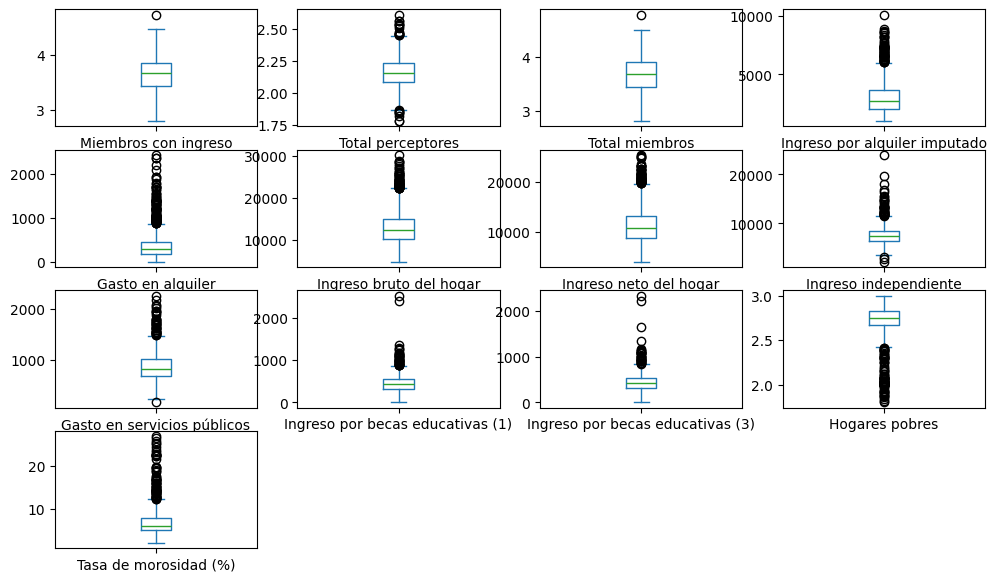

In [ ]:
import matplotlib.pyplot as plt
df_modelo_final.plot(kind='box', subplots=True, layout=(4,4), sharex=True, sharey=False,  figsize=[12,7])
plt.show()

In [ ]:
def corrige_outliers(dfx, columnas_lst):
  for columna in columnas_lst:
    q1 = dfx[columna].quantile(0.25)
    q3 = dfx[columna].quantile(0.75)
    iqr = q3 - q1
    ul = q3 + 1.5*iqr # upper_limit
    ll = q1 - 1.5*iqr # lower_limit
    dfx.loc[dfx[columna]>ul, columna] = ul
    dfx.loc[dfx[columna]<ll, columna] = ll
  return dfx

Para las variables 'Miembros con ingreso' y 'Total miembros' se les modifica los outliers por ser minoritarios,  no representan datos importantes y pueden alterar el comportamiento del modelo

In [ ]:
columnas_lst = ['Miembros con ingreso','Total miembros']
df_modelo_final = corrige_outliers(df_modelo_final, columnas_lst)

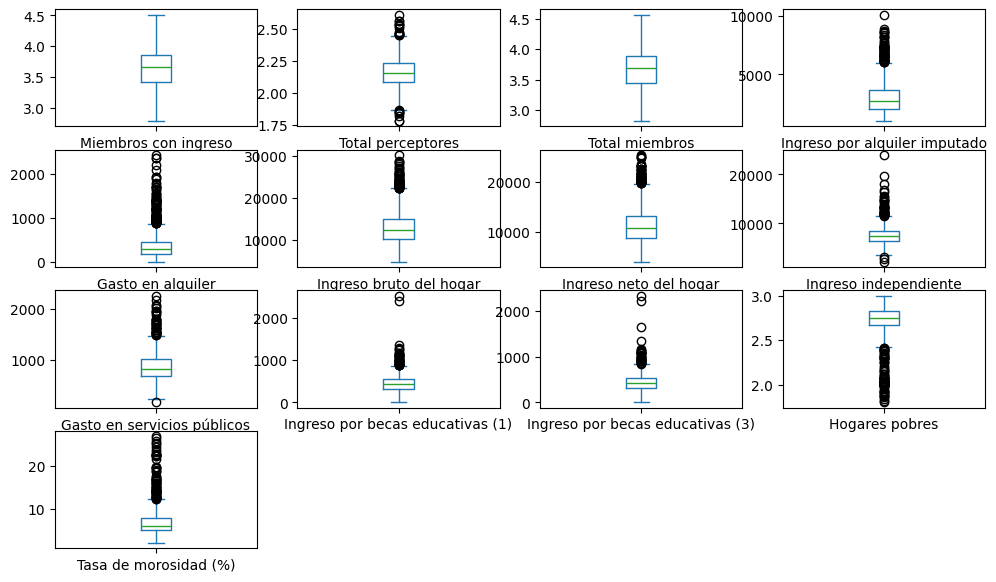

In [ ]:
df_modelo_final.plot(kind='box', subplots=True, layout=(4,4), sharex=True, sharey=False,  figsize=[12,7])
plt.show()

Se realiza un mapa de correlaciones de pearson para elimianr aquellos features que sean redundantes

In [ ]:
pd.set_option('display.precision', 2)  # setea la cantidad de decimales a mostrar en lo sucesivo en los dataframes

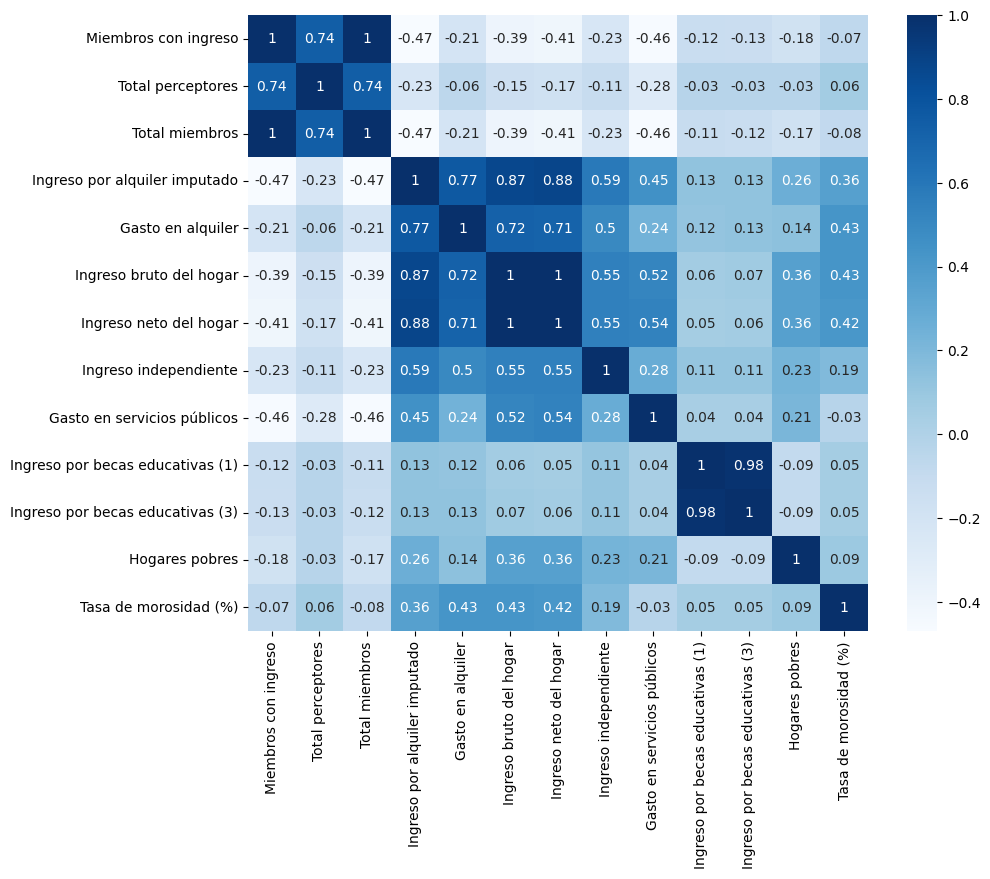

In [ ]:
import seaborn as sns

df_corr = df_modelo_final.corr(numeric_only=True).apply(lambda x: round(x,2))
plt.figure(figsize=(10,8))
sns.heatmap(df_corr,
            annot=True,
            cmap='Blues')
plt.show()

In [ ]:
df_modelo_final = df_modelo_final.drop(columns = ['Total miembros','Ingreso por alquiler imputado','Ingreso neto del hogar',
                                                  'Ingreso por becas educativas (3)'])

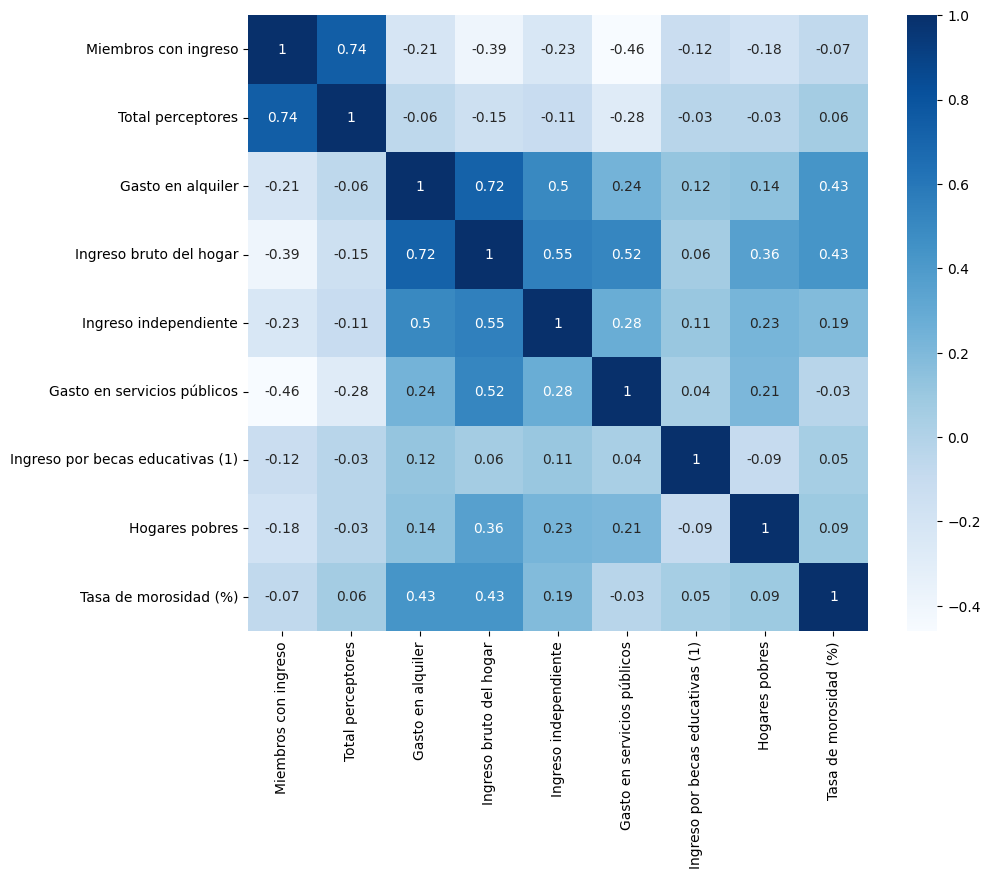

In [ ]:
df_corr = df_modelo_final.corr(numeric_only=True).apply(lambda x: round(x,2))
plt.figure(figsize=(10,8))
sns.heatmap(df_corr,
            annot=True,
            cmap='Blues')
plt.show()

In [ ]:
len(df_modelo_final)

1127

In [ ]:
# Asegúrate de que "Fecha" esté en formato datetime
df_modelo_final["Fecha"] = pd.to_datetime(df_modelo_final["Fecha"])
df_modelo_final=df_modelo_final.set_index('Fecha')

In [ ]:
df_modelo_final.head()

,Miembros con ingreso,Total perceptores,Gasto en alquiler,Ingreso bruto del hogar,Ingreso independiente,Gasto en servicios públicos,Ingreso por becas educativas (1),Hogares pobres,Caja Municipal,Tasa de morosidad (%)
Fecha,,,,,,,,,,
2009-05-01,4.14,2.21,190.86,8584.35,6653.65,621.43,260.24,2.59,CMAC Arequipa,5.08
2009-06-01,4.14,2.19,187.36,9365.31,6464.00,672.12,439.86,2.64,CMAC Arequipa,5.05
2009-07-01,4.20,2.20,190.98,9314.39,5655.81,782.44,409.41,2.64,CMAC Arequipa,5.21
2009-08-01,4.08,2.22,162.57,7445.07,6796.22,591.10,486.75,2.63,CMAC Arequipa,5.35
2009-09-01,4.13,2.20,245.83,10285.39,5911.57,690.85,390.66,2.63,CMAC Arequipa,5.01


In [ ]:
df_modelo_final.to_csv("df_modelo_final")

Ahora tenemos un dataset que contiene a todos los features y al target de morosidad divididos por clases ordenados por fecha.

Pre procesamiento listo!!!